## Problem Statement

Given the dataset of product reviews and recommendation status, we can build a text classification model that can correctly identify the users who will recommend the product in the future. 

**Review:** Customer review for the product

**Recommendation:** Customer's recommendation for the product 

## Table of Content

1. **[Import Libraries](#lib)**
2. **[Load the Data](#data)**
3. **[Data Exploration](#eda)**
4. **[Data Preperation](#prep)**
5. **[Data Split](#split)**
6. **[Machine Learning Modeling](#model)**
    - 6.1 - **[Count vectorizer](#cv)**
    - 6.2 - **[TF-IDF](#tfidf)**


<a id="lib"></a>
### Step 1 : Load required libraries 

In [5]:
#import the libraries
import numpy as np
import pandas as pd
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from nltk import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
     
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<a id="data"></a>
### Step 2 : Load the input data 

In [7]:
#read the input data
input_data = pd.read_csv('dataset.csv')
#scan the dataframe
input_data.head()

,Review,Recommend
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [8]:
#convert the object datatype type to string
input_data.info()
input_data['Review']=input_data['Review'].astype('str') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     22641 non-null  object
 1   Recommend  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [9]:
#check the size of the dataframe
input_data.shape

(23486, 2)

In [10]:
#check the target class distribution in the dataset
input_data['Recommend'].value_counts()

Recommend
1    19314
0     4172
Name: count, dtype: int64

As we can see there are around 23K+ reviews in the dataset. Each review has a corresponding recommendation value and there are more recommended products compared to non-recommended

<a id="eda"></a>
### Step 3 : Explore the data 

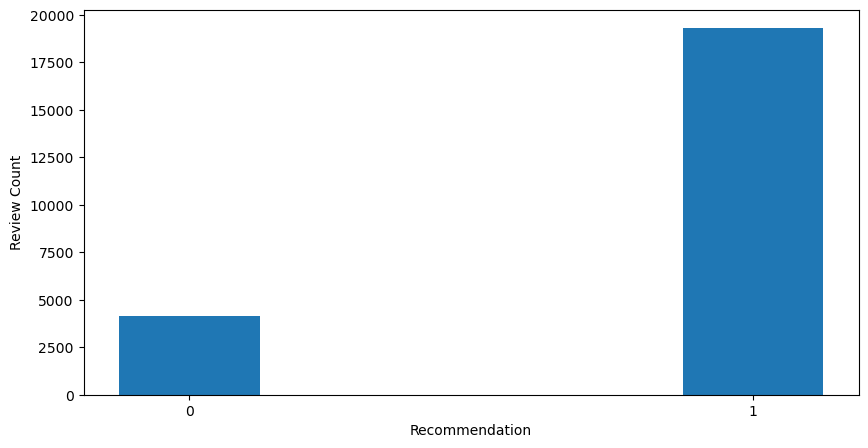

In [13]:
#check for the target class counts 
label_dist = input_data['Recommend'].value_counts().to_dict()
fig = plt.figure(figsize = (10, 5))
ax = plt.bar(label_dist.keys(), label_dist.values(), width=0.25)
plt.xticks([0,1])
plt.xlabel("Recommendation")
plt.ylabel("Review Count")
plt.show()

In [14]:
#check for any empty rows 
print(input_data.isnull().sum())

Review       0
Recommend    0
dtype: int64


In [15]:
#check for any duplicate reviews 
len(input_data['Review'])-len(input_data['Review'].drop_duplicates())


851

As we can observe there are 851 reviews which seem to be duplicate values. We will drop these from the dataframe.

In [17]:
#drop the repeated reviews 
input_data=input_data.drop_duplicates(subset='Review', keep="last")
input_data.shape

(22635, 2)

We can now check the size of each review to establish if there is any relation between the recommendation and length of the reviews 

In [19]:
#check for the length of reviews 
input_data['length']=input_data['Review'].apply(lambda x: len(x.split(' ')))

In [20]:
#validate the newly added column in the dataframe 
input_data.sample(10)

,Review,Recommend,length
17912,Cozy and beautiful - everything dreamy sleep p...,1,20
11147,I ordered this dress online in 8 p in the oran...,1,101
19256,This skirt is perfect. i'm a size 10 and i'm 4...,1,71
14980,I instantly fell in love with the graphic patt...,1,90
8524,"I loved the fit, color and style, but the fabr...",0,27
1719,Classic and stylish. trendy with the blocking....,1,23
18728,"The quality of the fabric is good, but the fit...",0,18
20753,"I was at my local retailer this weekend, needi...",1,97
19688,The colors in this skirt are gorgeous. a super...,1,75
3032,"I am 5'4"", 100lbs, petite frame, i bought this...",1,94


In [21]:
#avg. length for recommended and non recommended review 
print(round(input_data[input_data['Recommend']== 1 ]['length'].mean()))
print(round(input_data[input_data['Recommend']== 0]['length'].mean()))

60
62


Seems like there isn't much of a difference between size of the customer review in the dataset 

<a id="prep"></a>
### Step 4 : Data Preperation

Since the reviews are raw texts and contains multiple symbols, punctuations , hastags which might not be very useful for the modeling . 
We will use a helper function to clean the text and prepare it for modeling purpose.

In [25]:
# helper function to remove stopwords
input_data["Review_new"]=input_data["Review"].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [26]:
#helper function for review cleaning 
def text_clean(review):
    #lowercase the review
    review=review.lower()
    #remove punctuation 
    review = re.sub('[()!?]', ' ', review)
    review = re.sub('\[.*?\]',' ', review)
    #remove non alphanumeric occurences
    review = re.sub("[^a-z0-9]"," ", review)
    #remove the @mention
    review = re.sub("@[A-Za-z0-9_]+","", review)
    #remove the hastags
    review = re.sub("#[A-Za-z0-9_]+","", review)
    #remove any links 
    review = re.sub(r"http\S+", "", review)
    review = re.sub(r"www.\S+", "", review)
    return review

In [27]:
#apply the function on the review column 
input_data['clean_review'] = input_data['Review_new'].apply(text_clean)

In [28]:
#validate if the reviews are clean
input_data[['Review','clean_review']].sample(10)

,Review,clean_review
1824,Glad i got this on sale. it is more yellow tha...,glad got sale yellow photo short also heav...
16146,It is my favorite piece in my closet right now...,it favorite piece closet right now cute feel...
2988,I was so excited to find this shirt on sale at...,i excited find shirt sale local retailer store...
16361,I love ag jeans to begin with but even still s...,i love ag jeans begin even still sometimes cer...
14711,"The tank is very structured, thick yet breatha...",the tank structured thick yet breathable see...
5097,I am a big fan of maeve tops. i love the beadi...,i big fan maeve tops love beading structure t...
16628,Beautiful sweater!! i love the color and the f...,beautiful sweater love color fit cowl neck ...
4938,"This top is so darling, the different textures...",this top darling different textures elegant r...
902,"This top is super cute, however the bottom hem...",this top super cute however bottom hem frayed...
2434,This dress is definitely light weight and it r...,this dress definitely light weight requires sl...


We can now observe that each review looks much cleaner and neat post the data cleansing prcoess 

In [30]:
# Calculate updated length after removing the stopwords and cleaning review
input_data['new_length']=input_data['clean_review'].apply(lambda x: len(x.split(" ")))

In [31]:
#avg. length of the review for recommended and non-recommended labels 
print(round(input_data[input_data['Recommend']== 1]['new_length'].mean()))
print(round(input_data[input_data['Recommend']== 0]['new_length'].mean()))


41
41


Post the data cleaning, the avg. length of the review becomes the same 

<a id="split"></a>
### Step 5 : Data split 

Now we split the 23K+ data into training and test dataset. One thing to note is to split the data based on target class to maintain the class balance

In [35]:
#Sentiment Classifier
#split the data into training and test set with balanced split based on target class
X_train, X_test, y_train, y_test = train_test_split(input_data["clean_review"],
                                                    input_data["Recommend"],test_size=0.3,
                                                    stratify=input_data['Recommend'])

In [36]:
#check the shape of train and test data 
print(X_train.shape[0],X_test.shape[0])

15844 6791


In [37]:
#check the class balance in train data 
print(y_train.value_counts())

Recommend
1    12974
0     2870
Name: count, dtype: int64


In [38]:
#check the target class balance in test data 
print(y_test.value_counts())

Recommend
1    5561
0    1230
Name: count, dtype: int64


<a id="model"></a>
### Step 6  : ML Modeling and Performance evaluation

After splitting the data , we move on to the modelling part. Given we are doing text classification, we will convert the text data using two approaches :
1. Count Vectoriser 
2. TF-IDF 


<a id="cv"></a>
#### Using Count vectorizer

In [42]:
#Build a list of models to be trained and tested
modelclasses = [
    ["Logistic Regression", LogisticRegression],
    ["MNB", MultinomialNB],
    ["Random Forest", RandomForestClassifier]]

In [43]:
#Use the count vectoriser to convert the text data to numerical form
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#create an empty dataframe to log performance of the model based on score and auc
results = pd.DataFrame(columns = ['modelname','score','auc'])

for modelname, Model in modelclasses:
    model = Model()
    model.fit(X_train_vec, y_train)
    score = np.round(model.score(X_test_vec, y_test),2)
    auc=np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]),2)
    
    results.loc[len(results)] = [model, score, auc]
 

In [44]:
# Model performance 
results.head(5)

,modelname,score,auc
0,LogisticRegression(),0.89,0.92
1,MultinomialNB(),0.89,0.93
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.85,0.91


As we can observe , the Multinomial Naive Baysian performs the best out of all the models using count vectoriser 

<a id="tfidf"></a>
#### Using TF-IDF

In [47]:
#Use the tf-idf vectoriser to convert the text data to numerical form
vectorizertfidf = TfidfVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizertfidf.fit_transform(X_train)
X_test_vec = vectorizertfidf.transform(X_test)
results_tf = pd.DataFrame(columns = ['modelname','score','auc'])
for modelname, Model in modelclasses:
    model = Model()
    model.fit(X_train_vec, y_train)
    score = np.round(model.score(X_test_vec, y_test),2)
    auc=np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]),2)
    results_tf.loc[len(results_tf)] = [model, score, auc]


In [48]:
#model comparison 
results_tf.head(5)

,modelname,score,auc
0,LogisticRegression(),0.89,0.94
1,MultinomialNB(),0.82,0.91
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.85,0.91


Using the tf-idf vectoriser, we observe Logistic Regression outperforming the other models in terms of accuracy and auc.